# REMEDI: Demonstration using MNIST

## Package requirements:

Below is a list of main packages and their versions required to run the notebook. Please note that the list may not be exhaustive.

```
- torch: 2.0.1
- pytorch-lightning: 2.1.0
- tensorboard: 2.10.0
- scipy: 1.7.0
- numpy: 1.22.0
- matplotlib: 3.4.2
```

## Loading the necessary packages

In [1]:
import torch
import math
import scipy.special as sc
from progressbar import progressbar
import numpy as np
import random
from KNIFE import fit_kernel, MargKernel
from REMEDI_MLP import REMEDI
from network import nlIB_network,StatisticsNetwork
import matplotlib.pyplot as plt
import os
import psutil
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import pytorch_lightning as pl
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint,Callback
from utils import get_data,get_args
import re
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
from types import SimpleNamespace
import glob
path_src = os.getcwd()
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Defining the necessary functions

In [2]:
def get_args1(self,argv=None):
    parser = argparse.ArgumentParser(description='Train diff entropy')
    args = parser.parse_args(argv)
    return args


class EMALoss(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, running_ema):
        ctx.save_for_backward(input, running_ema)
        input_log_sum_exp = input.exp().mean().log()

        return input_log_sum_exp

    @staticmethod
    def backward(ctx, grad_output):
        input, running_mean = ctx.saved_tensors
        grad = grad_output * input.exp().detach() / \
            (running_mean + 1e-5) / input.shape[0]
        return grad, None
    

class standard_gaussian_sampler():
    def __init__(self,dim):
        self.d = dim
    def sample(self,n_samples,device_id):
        return torch.randn(n_samples,self.d).to(device_id)
    def logpdf(self,x,device_id):
        return -0.5 * torch.sum(x**2,dim=-1) - (torch.log(torch.tensor([2*math.pi]).to(device_id))*(self.d/2))
    
def u_func(r):
    return r ** 2


## IB model with different MI estimators

In [7]:
class VIB(pl.LightningModule):
    def __init__(self,repl_n,HY,n_x,n_y,compression_level,u_func,method,K,beta,dim_pen,network_type,dataset_name,problem_type,learning_rate,learning_rate_steps,learning_rate_drop,kd_estimator,remedi,use_f_div: bool,pi_prior=None,StatisticsNetwork=None,device_id=0):
        super().__init__()
        self.repl_n = repl_n
        torch.manual_seed(self.repl_n)
        self.HY = HY # in natts
        self.varY = 0
        self.IXT = 0
        self.ITY = 0
        self.HT_given_X = 0
        self.HT = 0
        self.comp0 = 0
        self.comp1 = 0
        self.comp2 = 0
        self.cor = 0
        self.n_x = n_x
        self.compression_level = compression_level
        self.u_func = u_func
        self.method = method        
        self.K = K
        self.beta = beta
        self.dim_pen = dim_pen         
        self.network = nlIB_network(K,n_x,n_y,network_type=network_type,method = self.method,device_id=device_id).to(device_id)
        if dataset_name == 'ImageNet':
            self.xavier_init(self.network)
        self.dataset_name = dataset_name
        self.pi_prior = pi_prior
        self.problem_type = problem_type
        self.automatic_optimization = False 
        self.learning_rate=learning_rate
        self.learning_rate_drop = learning_rate_drop 
        self.learning_rate_steps = learning_rate_steps
        if self.method == 'IB_w_KNIFE' or self.method == 'IB_w_REMEDI':
            self.kd_estimator = kd_estimator.to(device_id)
        elif self.method == 'IB_w_REMEDI_Gauss':
            self.kd_estimator = kd_estimator
        else:
            self.kd_estimator = None
        self.remedi = remedi.to(device_id) if remedi is not None else None
        self.use_f_div = use_f_div
        if self.dataset_name == 'mnist':
            self.StatisticsNetwork = StatisticsNetwork(n_x,K,device=device_id).to(device_id) if StatisticsNetwork is not None else None
        else:
            self.StatisticsNetwork = StatisticsNetwork(np.array(n_x).prod(),K,device=device_id).to(device_id) if StatisticsNetwork is not None else None
        self.running_mean = 0.
        self.device_id = device_id
        self.valid_block = False

    def xavier_init(self,model):
        for name, param in model.named_parameters():
            if name.endswith(".bias"):
                param.data.fill_(0)
            else:
                bound = math.sqrt(6) / math.sqrt(param.shape[0] + param.shape[1])
                param.data.uniform_(-bound, bound)

    def forward(self, x):
        logits_y = self.network(x)
        return logits_y

    def free_params(self,module: torch.nn.Module):
        for p in module.parameters():
            p.requires_grad = True

    def frozen_params(self,module: torch.nn.Module):
        for p in module.parameters():
            p.requires_grad = False


    def ema(self,mu, alpha, past_ema):
        return alpha * mu + (1.0 - alpha) * past_ema


    def ema_loss(self,x, running_mean=0., alpha=1.):
        t_exp = torch.exp(torch.logsumexp(x, 0) - math.log(x.shape[0])).detach()
        if running_mean == 0:
            running_mean = t_exp
        else:
            if t_exp <= (running_mean + 1e2):
                running_mean = self.ema(t_exp, alpha, running_mean.item())
            else:
                running_mean = self.ema(t_exp, 0, running_mean.item())
        t_log = EMALoss.apply(x, running_mean)

        # Recalculate ema

        return t_log, running_mean


    def get_IXT(self,mean_t,sigma_t,x=None,train_KNIFE: bool = False):

        if self.method == 'variational_IB':
            IXT = -0.5*(1+2*torch.log(sigma_t)-mean_t.pow(2)-sigma_t**2).sum(1).mean().div(math.log(2))

        elif self.method == 'IB_w_KNIFE':
            HT_given_X = (torch.log(sigma_t* torch.sqrt(2. * math.pi * torch.exp(torch.tensor([1.]))).to(self.device_id))).sum(1).mean()
            enc_sample = mean_t + sigma_t * torch.randn(mean_t.shape).to(self.device_id)
            HT = (-self.kd_estimator.logpdf(enc_sample)).mean()
            IXT = (HT - HT_given_X).div(math.log(2))
            self.HT = HT
            self.HT_given_X = HT_given_X
        elif self.method == 'IB_w_REMEDI_Gauss':
            HT_given_X = (torch.log(sigma_t* torch.sqrt(2. * math.pi * torch.exp(torch.tensor([1.]))).to(self.device_id))).sum(1).mean()
            vi_IXT = -0.5*(1+2*torch.log(sigma_t)-mean_t.pow(2)-sigma_t**2).sum(1).mean().div(math.log(2))
            with torch.no_grad():
                if HT_given_X == float('inf'):
                    HT_given_X = torch.tensor([1e5]).to(self.device_id)
                elif HT_given_X == float('-inf'):
                    HT_given_X = torch.tensor([-1e5]).to(self.device_id)

            enc_sample = mean_t + sigma_t * torch.randn(mean_t.shape).to(self.device_id)
            if self.valid_block:
                with torch.no_grad():
                    z = self.kd_estimator.sample(enc_sample.shape[0],device_id = self.device_id).float()
                comp1 = torch.mean(self.remedi(enc_sample.float()))
                if self.use_f_div:
                    comp2 = torch.mean(torch.exp(self.remedi(z) - 1))
                else:
                    mini_out = self.remedi(z)
                    comp2, self.running_mean = self.ema_loss(mini_out,running_mean=self.running_mean,alpha=0.01)
                    comp2 = comp2.clone()
                    if comp2 == float('inf'):
                        comp2 = comp1
                    elif comp2 == float('-inf'):
                        comp2 = comp1
                tmp1 = (comp1 - comp2).reshape(1)
                tmp = tmp1
                self.comp1 = comp1
                self.comp2 = comp2
                self.cor = tmp
                IXT = vi_IXT - tmp.div(math.log(2))
                self.HT = vi_IXT*(math.log(2)) + HT_given_X
                self.HT_given_X = HT_given_X
            elif self.trainer.current_epoch > 4:
                with torch.no_grad():
                    z = self.kd_estimator.sample(enc_sample.shape[0],device_id = self.device_id).float()

                comp1 = torch.mean(self.remedi(enc_sample.float()))
                if self.use_f_div:
                    comp2 = torch.mean(torch.exp(self.remedi(z) - 1))
                else:
                    mini_out = self.remedi(z)
                    comp2, self.running_mean = self.ema_loss(mini_out,running_mean=self.running_mean,alpha=0.01)
                    comp2 = comp2.clone()
                    if comp2 == float('inf'):
                        comp2 = comp1 
                    elif comp2 == float('-inf'):
                        comp2 = comp1 
                tmp1 = (comp1 - comp2).reshape(1)
                tmp = tmp1
                self.comp1 = comp1
                self.comp2 = comp2
                self.cor = tmp
                IXT = vi_IXT - tmp.div(math.log(2))
                self.HT = vi_IXT*(math.log(2)) + HT_given_X
                self.HT_given_X = HT_given_X
            elif self.trainer.current_epoch <= 4:
                IXT = vi_IXT
                self.HT = vi_IXT*(math.log(2)) + HT_given_X
                self.HT_given_X = HT_given_X

        elif self.method == 'IB_w_REMEDI':

            HT_given_X = (torch.log(sigma_t* torch.sqrt(2. * math.pi * torch.exp(torch.tensor([1.]))).to(self.device_id))).sum(1).mean()

            with torch.no_grad():
                if HT_given_X == float('inf'):
                    HT_given_X = torch.tensor([1e5]).to(self.device_id)
                elif HT_given_X == float('-inf'):
                    HT_given_X = torch.tensor([-1e5]).to(self.device_id)

            enc_sample = mean_t + sigma_t * torch.randn(mean_t.shape).to(self.device_id)
            if train_KNIFE:
                HT = (-self.kd_estimator.logpdf(enc_sample)).mean()
                with torch.no_grad():
                    if HT == float('inf'):
                        HT = torch.tensor([1e5]).to(self.device_id)
                    elif HT == float('-inf'):
                        HT = torch.tensor([-1e5]).to(self.device_id)
                IXT = (HT - HT_given_X).div(math.log(2))
            else:
                z = self.kd_estimator.sample((enc_sample.shape[0],)).float()

                comp0 = (-self.kd_estimator.logpdf(enc_sample)).mean()
                comp1 = torch.mean(self.remedi(enc_sample.float()))
                if self.use_f_div:
                    comp2 = torch.mean(torch.exp(self.remedi(z) - 1))
                else:
                    mini_out = self.remedi(z)
                    comp2, self.running_mean = self.ema_loss(mini_out,running_mean=self.running_mean,alpha=0.01)
                HT = comp0 - (comp1 - comp2)
                with torch.no_grad():
                    if HT == float('inf'):
                        HT = torch.tensor([1e5]).to(self.device_id)
                    elif HT == float('-inf'):
                        HT = torch.tensor([-1e5]).to(self.device_id)
                IXT = (HT - HT_given_X).div(math.log(2))
                self.HT = HT
                self.HT_given_X = HT_given_X

        elif self.method == 'IB_w_MINE':
            enc_sample = mean_t + sigma_t * torch.randn(mean_t.shape).to(self.device_id)
            enc_sample_marg = enc_sample[torch.randperm(enc_sample.shape[0])]
            t = self.StatisticsNetwork(torch.cat((x.view(x.shape[0],-1),enc_sample),dim=-1)).mean()
            t_marg = self.StatisticsNetwork(torch.cat((x.view(x.shape[0],-1),enc_sample_marg),dim=-1))
            second_term, self.running_mean = self.ema_loss(t_marg,running_mean=self.running_mean,alpha=0.01)
            IXT = (t - second_term).div(math.log(2))


        # NaNs and exploding gradients control
        with torch.no_grad():
            if self.u_func == 'shifted-exp':
                if IXT > self.compression_level:
                    IXT -= (IXT - self.compression_level - 0.01)
            if self.u_func(torch.Tensor([IXT])) == float('inf'):
                IXT = torch.Tensor([1e5])
            elif self.u_func(torch.Tensor([IXT])) == float('-inf'):
                IXT = torch.Tensor([-1e5])

        return IXT.to(self.device_id)
    

    def get_ITY(self,logits_y,y):
        if self.problem_type == 'classification':
            tmp = logits_y.clone()           
            tmp = tmp.reshape((logits_y.shape[0]*logits_y.shape[1],logits_y.shape[2]))
            y = y.repeat(logits_y.shape[0])            
            logits_y = tmp
            HY_given_T = torch.nn.CrossEntropyLoss()(logits_y,y)
            ITY = (self.HY - HY_given_T) / np.log(2) # in bits
            return ITY
        else:
            tmp = logits_y.clone()           
            tmp = tmp.reshape((logits_y.shape[0]*logits_y.shape[1],logits_y.shape[2]))
            y = y.repeat(logits_y.shape[0],1)            
            logits_y = tmp
            MSE = torch.nn.MSELoss()(logits_y,y)
            ITY = 0.5 * torch.log(varY / MSE) / np.log(2) # in bits
            return ITY , (HY - MSE) / np.log(2) # in bits

    def evaluate(self,logits_y,y):
        with torch.no_grad():
            if self.problem_type == 'classification':
                tmp = logits_y.clone()
                tmp = tmp.reshape((logits_y.shape[0]*logits_y.shape[1],logits_y.shape[2]))
                y = y.repeat(logits_y.shape[0])                
                logits_y = tmp
                y_hat = y.eq(torch.max(logits_y,dim=1)[1])
                accuracy = torch.mean(y_hat.float())
                return accuracy
            else: 
                tmp = logits_y.clone()
                tmp = tmp.reshape((logits_y.shape[0]*logits_y.shape[1],logits_y.shape[2]))
                y = y.repeat(logits_y.shape[0],1)                
                logits_y = tmp
                mse = torch.nn.MSELoss()(logits_y,y) 
                return mse
     
    def on_after_backward(self) -> None:
        valid_gradients = True
        if self.remedi is not None:
            for name, param in self.remedi.named_parameters():
                if param.grad is not None:
                    valid_gradients = not (torch.isnan(param.grad).any() or torch.isinf(param.grad).any())
                    if not valid_gradients:
                        break

            if not valid_gradients:
                print(f'detected inf or nan values in gradients. not updating model parameters',flush=True)
                self.zero_grad()
        if self.StatisticsNetwork is not None:
            for name, param in self.StatisticsNetwork.named_parameters():
                if param.grad is not None:
                    valid_gradients = not (torch.isnan(param.grad).any() or torch.isinf(param.grad).any())
                    if not valid_gradients:
                        break

            if not valid_gradients:
                print(f'detected inf or nan values in gradients. not updating model parameters',flush=True)
                self.zero_grad()


    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1) if self.dataset_name == 'mnist' else x
        if self.method == 'IB_w_KNIFE':
            self.frozen_params(self.kd_estimator)
            opt1 = self.optimizers()[1]
        if self.method == 'IB_w_REMEDI':
            self.frozen_params(self.kd_estimator)
            opt1 = self.optimizers()[1]
            self.frozen_params(self.remedi)
            opt2 = self.optimizers()[2]
        if self.method == 'IB_w_REMEDI_Gauss':
            self.frozen_params(self.remedi)
            opt2 = self.optimizers()[1]
        if self.StatisticsNetwork is not None:
            self.frozen_params(self.StatisticsNetwork)
            opt1 = self.optimizers()[1]
        
        self.free_params(self.network)
        opt = self.optimizers()[0] if self.kd_estimator is not None or self.StatisticsNetwork is not None else self.optimizers()
        sgd_train_logits_y = self.network(x)
        if self.problem_type =='classification':
            sgd_train_ITY = self.get_ITY(sgd_train_logits_y,y)
        else:
            sgd_train_ITY, sgd_train_ITY_lower = self.get_ITY(sgd_train_logits_y,y)
        mi_train_mean_t,mi_sigma_t = self.network.encode(x,random=False)
        if self.method != 'IB_w_MINE':
            mi_train_IXT = self.get_IXT(mi_train_mean_t,mi_sigma_t)
        else:
            mi_train_IXT = self.get_IXT(mi_train_mean_t,mi_sigma_t,x=x)
        opt.zero_grad()
        if self.problem_type == 'classification':
            loss = - 1.0 * (sgd_train_ITY - self.beta * self.u_func(mi_train_IXT))
        else: 
            loss = - 1.0 * (sgd_train_ITY_lower - self.beta * self.u_func(mi_train_IXT))
        self.manual_backward(loss)
        opt.step()
        self.frozen_params(self.network)


        if self.method == 'IB_w_KNIFE':
            opt1 = self.optimizers()[1]
            self.free_params(self.kd_estimator)
            for i_epoch in range(self.kd_estimator.epochs):
                opt1.zero_grad()
                loss1 = self.nested_training_step(batch,0)
                self.manual_backward(loss1)
                opt1.step()
            
            model_params = self.named_parameters()
            grad_norms = [(name,p.grad.detach().norm(float('inf'))) for name,p in model_params if p.grad is not None and re.search('kd_estimator',name) is not None]
            [self.trainer.logger.log_metrics({'max_grad_norm/{}'.format(name): torch.max(grad).item()}, step=self.trainer.global_step) for name,grad in grad_norms]
        elif self.method == 'IB_w_REMEDI':
            self.free_params(self.kd_estimator)
            for i_epoch in range(self.kd_estimator.epochs):
                opt1.zero_grad()
                loss1 = self.nested_training_step(batch,0,train_KNIFE=True)
                self.manual_backward(loss1)
                opt1.step()

            self.frozen_params(self.kd_estimator)
            self.free_params(self.remedi)

            for i_epoch in range(5):
                opt2.zero_grad()
                loss2 = self.nested_training_step(batch,0,train_KNIFE=False)
                self.manual_backward(loss2)
                opt2.step()

            model_params = self.named_parameters()
            grad_norms = [(name,p.grad.detach().norm(float('inf'))) for name,p in model_params if p.grad is not None and re.search('kd_estimator',name) is not None]
            [self.trainer.logger.log_metrics({'max_grad_norm/{}'.format(name): torch.max(grad).item()}, step=self.trainer.global_step) for name,grad in grad_norms]
        elif self.method == 'IB_w_REMEDI_Gauss':
            self.free_params(self.remedi)

            if self.trainer.current_epoch > 4:
                for i_epoch in range(30):
                    opt2.zero_grad()
                    loss2 = self.nested_training_step(batch,0,train_KNIFE=False)
                    self.manual_backward(loss2)
                    opt2.step()
            model_params = self.named_parameters()
            grad_norms = [(name,p.grad.detach().norm(float('inf'))) for name,p in model_params if p.grad is not None and re.search('kd_estimator',name) is not None]
            [self.trainer.logger.log_metrics({'max_grad_norm/{}'.format(name): torch.max(grad).item()}, step=self.trainer.global_step) for name,grad in grad_norms]
        elif self.method == 'IB_w_MINE':
            self.free_params(self.StatisticsNetwork)
            for i_epoch in range(5):
                opt1.zero_grad()
                loss1 = self.nested_training_step(batch,0)
                self.manual_backward(loss1)
                opt1.step()

        if self.method == 'IB_w_REMEDI':
            torch.nn.utils.clip_grad_norm_(list(self.network.parameters()) + list(self.kd_estimator.parameters()) + list(self.remedi.parameters()), 1.0)
        elif self.method == 'IB_w_REMEDI_Gauss':
            torch.nn.utils.clip_grad_norm_(list(self.network.parameters()) + list(self.remedi.parameters()), 1.0)
        elif self.method == 'IB_w_KNIFE':
            torch.nn.utils.clip_grad_norm_(list(self.network.parameters()) + list(self.kd_estimator.parameters()), 1.0)
        elif self.method == 'IB_w_MINE':
            torch.nn.utils.clip_grad_norm_(list(self.network.parameters()) + list(self.StatisticsNetwork.parameters()), 1.0)
        else:
            torch.nn.utils.clip_grad_norm_(list(self.network.parameters()), 1.0)

        # Logging to TensorBoard by default
        self.log("train_loss", loss,on_epoch=True,sync_dist=True)
        self.log("train_accuracy",self.evaluate(sgd_train_logits_y,y),on_epoch=True,sync_dist=True)
        self.log("train_IXT",(mi_train_IXT),on_epoch=True,sync_dist=True)
        self.log("train_HT",(self.HT),on_epoch=True,sync_dist=True)
        self.log("train_remedi",self.cor,on_epoch=True,sync_dist=True)
        self.log("train_running_mean",self.running_mean,on_epoch=True,sync_dist=True)
        self.log("train_ITY",(sgd_train_ITY),on_epoch=True,sync_dist=True)
        return loss

    def nested_training_step(self, batch, batch_idx,train_KNIFE: bool = False):
        x,_ = batch
        x = x.view(x.size(0), -1) if self.dataset_name == 'mnist' else x
        x = x.to(self.device_id)
        mi_train_mean_t,mi_sigma_t = self.network.encode(x,random=False)
        if not self.method == 'IB_w_MINE':
            loss1 = self.get_IXT(mi_train_mean_t,mi_sigma_t,train_KNIFE=train_KNIFE)
        else:
            loss1 = -self.get_IXT(mi_train_mean_t,mi_sigma_t,x=x)
        return loss1

    def on_train_epoch_end(self):
        sch = self.lr_schedulers()
        if (self.trainer.current_epoch + 1) % self.learning_rate_steps == 0:
            print("###########################")
            print('lr : {}'.format(sch.get_last_lr()[0]))
            sch.step()
            print('lr : {}'.format(sch.get_last_lr()[0]))

    def validation_step(self,val_batch,batch_idx):
        x, y = val_batch
        x = x.view(x.size(0), -1) if self.dataset_name == 'mnist' else x
        sgd_valid_logits_y = self.network(x)
        if self.problem_type =='classification':
            sgd_valid_ITY = self.get_ITY(sgd_valid_logits_y,y)
        else:
            sgd_valid_ITY, sgd_valid_ITY_lower = self.get_ITY(sgd_valid_logits_y,y)
        valid_mean_t,sigma_t = self.network.encode(x,random=False)
        if self.method != 'IB_w_MINE':
            valid_IXT = self.get_IXT(valid_mean_t,sigma_t)
        else:
            valid_IXT = self.get_IXT(valid_mean_t,sigma_t,x=x)
        if self.problem_type == 'classification':
            loss = - 1.0 * (sgd_valid_ITY - self.beta * self.u_func(valid_IXT))
        else: 
            loss = - 1.0 * (sgd_valid_ITY_lower - self.beta * self.u_func(valid_IXT))
        tmp = psutil.virtual_memory()
        print(f"Available:  {round(tmp.available/1024**3,2)}   Used:  {round(tmp.used/1024**3,2)}   Total  {round(tmp.total/1024**3,2)}   Shared:  {round(tmp.shared/1024**3,2)}",flush = True)
        # Logging to TensorBoard by default
        self.log("validation_ITY", sgd_valid_ITY,on_epoch=True,sync_dist=True)
        self.log("validation_IXT", valid_IXT,on_epoch=True,sync_dist=True)
        self.log("validation_HT", self.HT,on_epoch=True,sync_dist=True)
        self.log("validation_HT_giv_X", self.HT_given_X,on_epoch=True,sync_dist=True)
        self.log("validation_remedi",self.cor,on_epoch=True,sync_dist=True)
        self.log("validation_running_mean",self.running_mean,on_epoch=True,sync_dist=True)
        self.log("validation_loss", loss,on_epoch=True,sync_dist=True)
        sgd_valid_logits_y = self.network.decode(valid_mean_t)
        self.log("validation_accuracy",self.evaluate(sgd_valid_logits_y[None,:,:],y),on_epoch=True,sync_dist=True)
    def configure_optimizers(self):
        if self.method == 'IB_w_KNIFE':
            if self.dataset_name == 'CIFAR10':
                optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate,weight_decay=5e-4)
                optimizer1 = torch.optim.Adam(self.kd_estimator.parameters(), lr=self.kd_estimator.lr)
            else:
                optimizer = torch.optim.Adam(self.network.parameters(), lr=self.learning_rate)
                optimizer1 = torch.optim.Adam(self.kd_estimator.parameters(), lr=self.kd_estimator.lr)
            learning_rate_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, \
                step_size=1,gamma=self.learning_rate_drop)
            return [optimizer,optimizer1],[learning_rate_scheduler]
        elif self.method == 'IB_w_REMEDI':
            if self.dataset_name == 'CIFAR10':
                optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate,weight_decay=5e-4)
                optimizer1 = torch.optim.Adam(self.kd_estimator.parameters(), lr=self.kd_estimator.lr)
            else:
                optimizer = torch.optim.Adam(self.network.parameters(), lr=self.learning_rate)
                optimizer1 = torch.optim.Adam(params = self.kd_estimator.parameters(), lr=self.kd_estimator.lr)
            optimizer2 = torch.optim.Adam(self.remedi.parameters(), lr=0.001)
            learning_rate_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, \
                step_size=1,gamma=self.learning_rate_drop)
            return [optimizer,optimizer1,optimizer2],[learning_rate_scheduler]
        elif self.method == 'IB_w_REMEDI_Gauss':
            if self.dataset_name == 'CIFAR10':
                optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate,weight_decay=5e-4)
            else:
                optimizer = torch.optim.Adam(self.network.parameters(), lr=self.learning_rate)
            optimizer2 = torch.optim.Adam(self.remedi.parameters(), lr=0.0001)
            learning_rate_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, \
                step_size=1,gamma=self.learning_rate_drop)
            return [optimizer,optimizer2],[learning_rate_scheduler]
        elif self.method == 'IB_w_MINE':
            if self.dataset_name == 'CIFAR10':
                optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate,weight_decay=5e-4)
                optimizer1 = torch.optim.Adam(self.StatisticsNetwork.parameters(), lr=0.001)
            else:
                optimizer = torch.optim.Adam(self.network.parameters(), lr=self.learning_rate)
                optimizer1 = torch.optim.Adam(self.StatisticsNetwork.parameters(), lr=0.001)
            learning_rate_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, \
                step_size=1,gamma=self.learning_rate_drop)
            return [optimizer,optimizer1],[learning_rate_scheduler]
        else:
            if self.dataset_name == 'CIFAR10':
                optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate,weight_decay=5e-4)
            else:
                optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
            learning_rate_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, \
                step_size=1,gamma=self.learning_rate_drop)
            return [optimizer],[learning_rate_scheduler]


## Initializing the key hyperparameters

In [9]:
global name_base,args,logs_dir,models_dir
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_epochs = 10
repl_n = 1
beta = 10.**np.arange(-9,2,1)[0] #np.linspace(0,1,50)[int(beta)]#[0.,0.01,0.03,0.05,0.07,0.09][int(beta)] 
dim_pen = 1.
u_func_name = "pow"
hyperparameter = 1.
compression_level = 1.
K = 2
sgd_batch_size = 200
dataset_name = 'mnist'
if dataset_name == 'mnist':
        trainset, validationset = get_data(dataset_name)
        n_x = 784
        n_y = 10
        network_type = 'mlp_mnist'
        maxIXY = np.log2(10)
        HY = np.log(n_y)
        problem_type = 'classification'
        TEXT = None
        deterministic = True
elif dataset_name == 'ImageNet':
        trainset, validationset = get_data(dataset_name)
        n_x = 1536
        n_y = 1000
        network_type = 'mlp_ImageNet'
        maxIXY = np.log2(1000)
        HY = np.log(n_y)
        problem_type = 'classification'
        TEXT = None
        deterministic = True
elif dataset_name == 'CIFAR10':
        trainset, validationset = get_data(dataset_name)
        n_x = (3,32,32)
        n_y = 10
        network_type = 'mlp_CIFAR10'
        maxIXY = np.log2(n_y)
        HY = np.log(n_y)
        problem_type = 'classification'
        TEXT = None
        deterministic = True
optimizer_name = 'adam'
method = 'IB_w_REMEDI'
learning_rate = 0.0001
learning_rate_drop = 0.6
learning_rate_steps = 10
torch.manual_seed(1)
np.random.seed(1)
def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed) 
g = torch.Generator()
g.manual_seed(1)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=sgd_batch_size,num_workers=50,worker_init_fn=seed_worker,generator=g, \
                    shuffle=True,persistent_workers=True, multiprocessing_context='fork',pin_memory=True)
test_loader = torch.utils.data.DataLoader(validationset,batch_size=len(validationset),num_workers=4
                    ,shuffle=False,multiprocessing_context='fork',persistent_workers=True,pin_memory=True)

if method == 'IB_w_REMEDI':
        if dataset_name == 'CIFAR10' or dataset_name == 'mnist':
            num_modes = 10
        elif dataset_name == 'ImageNet':
            num_modes = 1
        mi_epochs = 5
        lr = 0.001
        cov_diagonal = 'var'
        cov_off_diagonal = 'var'
        average = 'var'
        use_tanh = False
        dimension = K
        args_adaptive = SimpleNamespace(optimize_mu=True,
                                    marg_modes=num_modes,
                                    batch_size=num_modes,
                                    use_tanh=use_tanh,
                                    init_std=1e-2,
                                    cov_diagonal=cov_diagonal,
                                    cov_off_diagonal=cov_off_diagonal,
                                    average=average,
                                    lr = lr,
                                    epochs = mi_epochs
                                    )
        if dataset_name == 'mnist' or dataset_name == 'CIFAR10' or dataset_name == 'ImageNet':
            kd_estimator = MargKernel(args_adaptive,dimension,None,None)
        remedi_estimator = REMEDI(base_dist = kd_estimator, train_base_dist= True, hidden_dim = [100,100 ,1], one_hot_y=False)
        StatisticsNetwork = None        

logs_dir = "../output/python/logs/" + dataset_name + "/" + u_func_name + '_' + str(round(hyperparameter,2)).replace('.', '-') + "_repl_" + str(repl_n) + '_' + method + '/'
models_dir = "../output/python/models/" + dataset_name + "/" + u_func_name + '_' + str(round(hyperparameter,2)).replace('.', '-') + "_repl_" + str(repl_n) + '_' + method + '/'


## Training the model:

For demonstration, we are running the IB model for **10 epochs** using the $\texttt{REMEDI}$ with KNIFE base distribution.

In [ ]:
model = VIB(repl_n,HY,n_x,n_y,compression_level,
                    u_func,method,K,beta,dim_pen,network_type,dataset_name,
                    problem_type,learning_rate,learning_rate_steps,
                    learning_rate_drop,kd_estimator,remedi = remedi_estimator,
                    use_f_div=False,StatisticsNetwork=StatisticsNetwork,device_id=0)

os.makedirs(models_dir,exist_ok=True) if not os.path.exists(models_dir) else None

tb_logger = pl_loggers.TensorBoardLogger(save_dir=logs_dir+"lightning_logs_K_{}_B_{}_ep{}/".format(K,beta,n_epochs),name="model_{}".format(repl_n))
checkpoint_callback = ModelCheckpoint(dirpath=models_dir+"lightning_logs_K_{}_B_{}_ep{}/".format(K,beta,n_epochs), save_top_k=1, monitor="validation_loss",save_last=True)
trainer = pl.Trainer(accelerator="gpu", profiler='advanced', devices=[dev], max_epochs=n_epochs, callbacks=[TQDMProgressBar(refresh_rate=20),checkpoint_callback],logger=tb_logger)

trainer.fit(model,train_dataloaders=train_loader,val_dataloaders=test_loader)

## Evaluation function

In [8]:
def eval_overall_model(n_epochs=10,viz=True,K=32,repl_n=1,beta_id=1,dataset_name = 'mnist',method = 'IB_w_KNIFE',file_name='IB_w_KNIFE',use_f_div=True,net=StatisticsNetwork):
    os.chdir(path_src)
    model_base_dir = '../output/python/models/'
    figs_base_dir = '../output/python/figures/'
    figs_new_dir = 'mse/'

    np.random.seed(456)
    torch.manual_seed(456)

    if dataset_name == 'mnist':
        trainset, validationset = get_data(dataset_name)
        n_x = 784
        n_y = 10
        network_type = 'mlp_mnist'
        maxIXY = np.log2(10)
        HY = np.log(n_y)
        problem_type = 'classification'
        TEXT = None
        deterministic = True
        model_base_dir = model_base_dir + dataset_name + '/'
        figs_base_dir = figs_base_dir + dataset_name + '/'  + figs_new_dir
        train_loader = torch.utils.data.DataLoader(trainset, \
                                        batch_size=10,num_workers=1,shuffle=False)
        validation_loader = torch.utils.data.DataLoader(validationset, \
                                        batch_size=len(validationset),num_workers=1,shuffle=False)        
        beta = 10.**np.arange(-9,0,1)[(int(beta_id)-1)]
        name_base = f"pow_1-0_repl_{repl_n}_"+file_name+"/lightning_logs_K_{}_B_{}_ep{}/".format(K,beta,n_epochs)
        method_name = method
    

    def parallel(j,train=False,viz=False):
        os.chdir(path_src)
        mod_models_dir =  model_base_dir + name_base
        _,(train_x,train_y) = next(enumerate(train_loader))
        _,(testset_x,testset_y) = next(enumerate(validation_loader))
        x = testset_x.to(dev)
        y = testset_y.to(dev)
        train_x = train_x.cuda()
        train_y = train_y.cuda()
        os.chdir(mod_models_dir)
        ckpt_name = glob.glob("epoch*.ckpt")

        if method_name == 'IB_w_REMEDI':
            num_modes = 10
            mi_epochs = 5
            lr = 0.001
            cov_diagonal = 'var'
            cov_off_diagonal = 'var'
            average = 'var'
            use_tanh = False
            device = dev
            dimension = K
            print_log = True
            args_adaptive = SimpleNamespace(optimize_mu=True,
                                        marg_modes=num_modes,
                                        batch_size=num_modes,
                                        use_tanh=use_tanh,
                                        init_std=1e-2,
                                        cov_diagonal=cov_diagonal,
                                        cov_off_diagonal=cov_off_diagonal,
                                        average=average,
                                        lr = lr,
                                        epochs = mi_epochs
                                        )
            kd_estimator = MargKernel(args_adaptive,dimension,None,None)
            remedi_estimator = REMEDI(base_dist = kd_estimator, train_base_dist= True, hidden_dim = [100,100 ,1], one_hot_y=False)
            StatisticsNetwork = None 
        elif method_name == 'IB_w_KNIFE':
            num_modes = 10 # 10 digits
            mi_epochs = 5
            lr = 0.001
            cov_diagonal = 'var'
            cov_off_diagonal = 'var'
            average = 'var'
            use_tanh = False
            device = dev
            dimension = K
            print_log = True
            args_adaptive = SimpleNamespace(optimize_mu=True,
                                        marg_modes=num_modes,
                                        batch_size=num_modes,
                                        use_tanh=use_tanh,
                                        init_std=1e-2,
                                        cov_diagonal=cov_diagonal,
                                        cov_off_diagonal=cov_off_diagonal,
                                        average=average,
                                        lr = lr,
                                        epochs = mi_epochs
                                        )
            kd_estimator = MargKernel(args_adaptive,dimension,None,None)       
            remedi_estimator = None
            StatisticsNetwork = None
        elif args.method == 'IB_w_REMEDI_Gauss':
            kd_estimator = standard_gaussian_sampler(K)
            remedi_estimator = REMEDI(base_dist = kd_estimator, train_base_dist= True, hidden_dim = [100,100 ,1], one_hot_y=False)
            StatisticsNetwork = None        
        elif method_name == 'IB_w_MINE':
            kd_estimator = None
            remedi_estimator = None
            StatisticsNetwork = net
        else:
            kd_estimator = None
            remedi_estimator = None
            StatisticsNetwork = None 
        

        model_data_K = VIB.load_from_checkpoint(ckpt_name[0],repl_n=repl_n,HY=HY,n_x=n_x,n_y=n_y,a=1,b=1,compression_level=1,
                                                  u_func= lambda r: r ** (1+1),method=method_name,K=K,beta=beta,dim_pen=1.,
                                                  network_type=network_type,dataset_name=dataset_name,pi_prior=torch.tensor([1.]),
                                                  problem_type=problem_type,learning_rate=0.001,learning_rate_steps=10,
                                                  learning_rate_drop=0.6,kd_estimator=kd_estimator,remedi=remedi_estimator,
                                                  use_f_div=use_f_div,StatisticsNetwork=StatisticsNetwork,map_location='cuda:0')
        model_data_K.to(dev).eval()
        with torch.no_grad():
            if train:
                x = train_x
                y = train_y
            x = x
            valid_mean_t,sigma_t = model_data_K.network.encode(x,random=False)
            # Taking one sample from the encoder
            enc_samples = valid_mean_t + sigma_t * torch.randn(valid_mean_t.shape).cuda()
            sgd_valid_logits_y = model_data_K.network.decode(enc_samples)
            if problem_type =='classification':
                sgd_valid_ITY = model_data_K.get_ITY(sgd_valid_logits_y[None,:,:],y)
            else:
                sgd_valid_ITY, sgd_valid_ITY_lower = model_data_K.get_ITY(sgd_valid_logits_y,y)
            if method_name != 'IB_w_MINE':
                valid_IXT = model_data_K.get_IXT(valid_mean_t,sigma_t)
            else:
                valid_IXT = model_data_K.get_IXT(valid_mean_t,sigma_t,x=x)
            if model_data_K.problem_type == 'classification':
                loss = - 1.0 * (sgd_valid_ITY - model_data_K.beta * model_data_K.u_func(valid_IXT))
            else: 
                loss = - 1.0 * (sgd_valid_ITY_lower - model_data_K.beta * model_data_K.u_func(valid_IXT))
            acc = model_data_K.evaluate(sgd_valid_logits_y[None,:,:],y)
            LL =  model_data_K.get_ITY(sgd_valid_logits_y[None,:,:],y)
            
            if viz:
                enc_sample = valid_mean_t + sigma_t * torch.randn(valid_mean_t.shape).to(dev)
                knife_sample = model_data_K.kd_estimator.sample((enc_sample.shape[0],)).float()
                enc_sample = enc_sample.cpu().numpy()
                z1 = np.linspace(min(enc_sample[:,0]),max(enc_sample[:,0]),50)
                z2 = np.linspace(min(enc_sample[:,1]),max(enc_sample[:,1]),50)
                z1v,z2v = np.meshgrid(z1,z2)
                z12_grid = torch.tensor(np.stack((z1v,z2v))).float().cuda().flatten(1,2).T
                z = torch.cat((z12_grid,valid_mean_t.mean(0)[None,2:].repeat(2500,1)),dim=-1)
                knife = np.exp(model_data_K.kd_estimator.logpdf(z).cpu().numpy())
                remedi = model_data_K.remedi(z).cpu().numpy()
                remedi_den = knife.squeeze()*np.exp(remedi).squeeze()
                plt.scatter(enc_sample[:,0],enc_sample[:,1],c='r',s=1)
                plt.title('Encoder samples')
                plt.show()
                plt.contour(z1v,z2v,knife.reshape(50,50),levels=50)
                plt.title('KNIFE')
                plt.colorbar()
                plt.show()
                plt.contour(z1v,z2v,remedi_den.reshape(50,50),levels=50)
                plt.title('REMEDI')
                plt.colorbar()
                plt.show()

            
        return acc,LL

    Test = parallel(0,viz=viz)
    Train = parallel(0,train=True)
    return Test,Train

## Evaluating the trained model

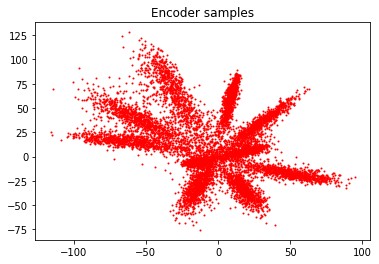

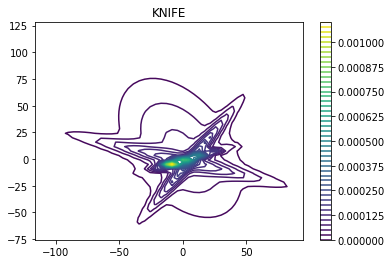

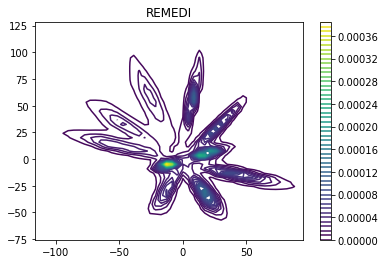

Train accuracy: 1.0
Test accuracy: 0.9246000051498413
Train LL: 3.185117244720459
Test LL: 2.803051233291626


In [9]:
IB_w_REMEDI = {}
i=1
j=1
IB_w_REMEDI[f'Beta_{i}_repl_{j}'] = eval_overall_model(n_epochs=10,K=2,repl_n=j,beta_id=i,method='IB_w_REMEDI',file_name='IB_w_REMEDI')
print(f"Train accuracy: {IB_w_REMEDI['Beta_1_repl_1'][1][0]}")
print(f"Test accuracy: {IB_w_REMEDI['Beta_1_repl_1'][0][0]}")
print(f"Train LL: {IB_w_REMEDI['Beta_1_repl_1'][1][1]}")
print(f"Test LL: {IB_w_REMEDI['Beta_1_repl_1'][0][1]}")